# Functions

Some functions that i wrote

In [1]:
#################
#### IMPORTS ####
#################

# Profiling
import cProfile, pstats, io
from pstats import SortKey

# Arrays
import numpy as np

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb

In [ ]:
def pro_profiler(func):
    '''Generic profiler. Expects an argument-free function.
    e. g. func = lambda: learning_epoch_SGD(mps, imgs, 3, 0.1).
    Prints and returns the profiling report trace.'''
    # TODO: adapt to write trace to file
    pr = cProfile.Profile()
    pr.enable()
    func()
    pr.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())
    return s

In [2]:
'''
Wrapper for type checks.
While defining a function, you can add the wrapper
stating the expected types:
> @arg_val(class_1, class_2, ...)
> def function(a, b, ...): 
'''
def arg_val(*args):
    def wrapper(func):
        def validating(*_args):
            if any(type(_arg)!=arg for _arg, arg in zip(_args,args)):
                raise TypeError('wrong type!')
            return func(*_args)
        return validating
    return wrapper

In [3]:
@arg_val(int, int, float)
def get_data(train_size = 1000, test_size = 100, grayscale_threshold = .5):
    '''
    Prepare the MNIST dataset for the training algorithm:
     * Choose randomly a subset from the whole dataset
     * Flatten each image to mirror the mps structure
     * Normalize images from [0,255] to [0,1]
     * Apply a threshold for each pixels so that each value 
       below that threshold are set to 0, the others get set to 1.
       For this algorithm we will only deal to binary states {0,1}
       instead of a range from 0 to 1    
    '''
    # Download all data
    mnist = torchvision.datasets.MNIST('classifier_data', train=True, download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]) )
    
    # Convert torch.tenor to numpy
    npmnist = mnist.data.numpy()
    
    # Check of the type of the sizes
    #if ((type(train_size) != int) or (type(test_size) != int)):
    #    raise TypeError('train_size and test_size must be INT')
    
    # Check if the training_size and test_size requested are bigger than
    # the MNIST whole size
    if ( (train_size + test_size) > npmnist.shape[0] ):
        raise ValueError('Subset too big')
    
    # Check of the positivity of sizes
    if ( (train_size <= 0) or (test_size <= 0) ):
        raise ValueError('Size of training set and test set cannot be negative')
    
    # Choose just a subset of the data
    # Creating a mask by randomly sampling the indexes of the full dataset
    subset_indexes = np.random.choice(np.arange(npmnist.shape[0]), size=(train_size + test_size), 
                                      replace=False, p=None)
    
    # Apply the mask
    npmnist = npmnist[subset_indexes]
    
    # Flatten every image
    npmnist = np.reshape(npmnist, (npmnist.shape[0], npmnist.shape[1]*npmnist.shape[2]))
    
    # Normalize the data from 0 - 255 to 0 - 1
    npmnist = npmnist/npmnist.max()
    
    # As in the paper, we will only deal with {0,1} values, not a range
    
    if ((grayscale_threshold <= 0) or (grayscale_threshold >= 1)):
        raise ValueError('grayscale_threshold must be in range ]0,1[')
    
    npmnist[npmnist > grayscale_threshold] = 1
    npmnist[npmnist <= grayscale_threshold] = 0
    
    # Return training set and test set
    return npmnist[:train_size], npmnist[train_size:]

@arg_val(np.ndarray, bool, str)
def plot_img(img_flat, flip_color = True, savefig = ''):
    '''
    Display the image from the flattened form
    '''
    # If the image is corrupted for partial reconstruction (pixels are set to -1)
    if -1 in img_flat:
        img_flat = np.copy(img_flat)
        img_flat[img_flat == -1] = 0
    
    # Background white, strokes black
    if flip_color:
        plt.imshow(1-np.reshape(img_flat,(28,28)), cmap='gray')
    # Background black, strokes white
    else:
        plt.imshow(np.reshape(img_flat,(28,28)), cmap='gray')
        
    plt.axis('off')
    
    if savefig != '':
        # save the picture as svg in the location determined by savefig
        plt.savefig(savefig, format='svg')
        plt.show()
        

In [4]:
train_set, test_set = get_data()

In [5]:
train_set.shape

(1000, 784)

In [6]:
test_set.shape

(100, 784)

In [7]:
type(train_set[1])

numpy.ndarray

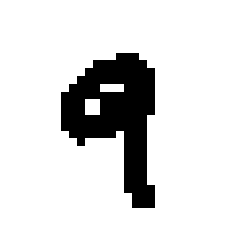

In [8]:
plot_img(train_set[1], True, '')

In [9]:
train_set[0].shape[0]

784

In [11]:
# Create a simple MPS network randomly initialized
mps = qtn.MPS_rand_state(L=28*28, bond_dim=5)

In [12]:
def get_p_img(mps, img):
    '''
    Contract the MPS network with an image to compute its probability
    P(img) = (<mps|img><img|mps>)/<mps|mps>
    '''
    if (len(mps.tensors) != img.shape[0]):
        raise ValueError('Length of MPS and size of image do not match')
    
    # Compute denominator
    Z = mps.H @ mps # Does it acknowledge canonicalization to speed computations?
                    # TO DO: check documentation
        
    # Contract image with mps
    P = 0
    # From left to right...
    for body in range(img.shape[0]):
        # if pixel is 0:
        if img[body] == 0:
            state = [1,0]
        # if pixel is 1:
        elif img[body] == 1:
            state = [0,1]
        else:
            raise ValueError('Found invalid pixel in image')
        
        if body == img.shape[0] - 1:
            newtensor = np.einsum('i,ik', carried_value, mps.tensors[body].data)
            P = np.einsum('i,i', state, newtensor)
        elif body > 0:
            newtensor = np.einsum('i,ikj', carried_value, mps.tensors[body].data)
            carried_value = np.einsum('i,ik', state, newtensor)
        else:
            carried_value = np.einsum('i,ki', state, mps.tensors[body].data)
        
        P = (P*P)/Z
        
    return P

In [13]:
train_set[0].shape

(784,)

In [14]:
def partial_removal_img(mnistimg, fraction = .5, axis = 0):
    '''
    Corrupt (with -1 values) a portion of an input image (from the test set)
    to test if the algorithm can reconstruct it
    '''
    # Check type:
    if [type(mnistimg), type(fraction), type(axis)] != [np.ndarray, float, int]:
        raise TypeError('Input types not valid')
    
    # Check the shape of input image
    if (mnistimg.shape[0] != 784):
        raise TypeError('Input image shape does not match, need (784,)')
    
    # Axis can be either 0 (rowise deletion) or 1 (columnwise deletion)
    if not(axis in [0,1]):
        raise ValueError('Invalid axis [0,1]')
    
    # Fraction must be from 0 to 1
    if (fraction < 0 or fraction > 1):
        raise ValueError('Invalid value for fraction variable (in interval [0,1])')
        
    mnistimg_corr = np.copy(mnistimg)
    mnistimg_corr = np.reshape(mnistimg_corr, (28,28))
    
    if axis == 0:
        mnistimg_corr[int(28*(1-fraction)):,:] = -1
    else:
        mnistimg_corr[:,int(28*(1-fraction)):] = -1
        
    mnistimg_corr = np.reshape(mnistimg_corr, (784,))
    
    return mnistimg_corr

In [15]:
aaa = partial_removal_img(test_set[0], fraction = .3, axis = 0)

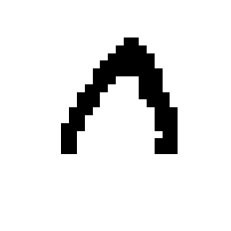

In [16]:
plot_img(aaa)

In [17]:
def initialize_mps(Ldim = 28*28, bdim = 30, canonicalize = 1):
    '''
    Initialize the MPS tensor network
    1. Create the MPS TN
    2. Canonicalization
    3. Renaming indexes
    '''
    # Create a simple MPS network randomly initialized
    mps = qtn.MPS_rand_state(L=Ldim, bond_dim=bdim)
    
    # Canonicalize: use a canonicalize value out of range to skip it (such as -1)
    if canonicalize in range(Ldim):
        mps.canonize(canonicalize)
        
    # REINDEXING TENSORS FOR A EASIER DEVELOPING
    # during initializations, the index will be named using the same notation of the 
    # Pan Zhang et al paper:
    #  ___       ___                      ___
    # |I0|--i0--|I1|--i1-... ...-i(N-1)--|IN|
    #  |         |                        |
    #  | v0      | v1                     | vN
    #  V         V                        V
    
    # Reindexing the leftmost tensor
    mps = mps.reindex({mps.tensors[0].inds[0]: 'i0', 
                       mps.tensors[0].inds[1]: 'v0'})
    
    # Reindexing the inner tensors through a cycle
    for tensor in range(1,len(mps.tensors)-1):
        mps = mps.reindex({mps.tensors[tensor].inds[0]: 'i'+str(tensor-1),
                           mps.tensors[tensor].inds[1]: 'i'+str(tensor),
                           mps.tensors[tensor].inds[2]: 'v'+str(tensor)})
    
    # Reindexing the last tensor
    tensor = tensor + 1
    mps = mps.reindex({mps.tensors[tensor].inds[0]: 'i'+str(tensor), 
                       mps.tensors[tensor].inds[1]: 'v'+str(tensor)})  
    
    return mps

In [18]:
mps = initialize_mps(Ldim=5)

In [19]:
mps.tensors

(Tensor(shape=(2, 2), inds=('i0', 'v0'), tags=oset(['I0'])),
 Tensor(shape=(2, 8, 2), inds=('i0', 'i1', 'v1'), tags=oset(['I1'])),
 Tensor(shape=(8, 4, 2), inds=('i1', 'i2', 'v2'), tags=oset(['I2'])),
 Tensor(shape=(4, 2, 2), inds=('i2', 'i4', 'v3'), tags=oset(['I3'])),
 Tensor(shape=(2, 2), inds=('i4', 'v4'), tags=oset(['I4'])))

In [20]:
def quimb_transform_img2state(img):
    '''
    Trasform an image to a tensor network to fully manipulate
    it using quimb, may be very slow, use it for checks
    '''
    
    # Initialize empty tensor
    img_TN = qtn.Tensor()
    for k, pixel in enumerate(img):
        if pixel == 0: # if pixel is 0, we want to have a tensor with data [0,1]
            img_TN = img_TN &  qtn.Tensor(data=[0,1], inds=['v'+str(k)], )
            
        else: # if pixel is 1, we want to have a tensor with data [1,0]
            img_TN = img_TN &  qtn.Tensor(data=[1,0], inds=['v'+str(k)], )
     
    # |  | 781 |
    # O  O ... O
    return img_TN

In [39]:
def computepsi(mps, img):
    '''
    Contract the MPS with the states (pixels) of a binary{0,1} image
    
    PSI:    O-...-O-O-O-...-O
            |     | | |     |
            |     | | |     |
    IMAGE:  O     O O O     O
    
    Images state are created the following way:
    if pixel is 0 -> state = [0,1]
    if pixel is 1 -> state = [1,0]
    '''
    
    # Left most tensor
    #          O--
    # Compute  |  => O--
    #          O
    if img[0] == 0:
        contraction = np.einsum('a,ba',[0,1], mps.tensors[0].data)
    else:
        contraction = np.einsum('a,ba',[1,0], mps.tensors[0].data)
        
    # Remove the first and last pixels because in the MPS
    # They need to be treated differently
    for k, pixel in enumerate(img[1:-1]):
        #  
        # Compute  O--O--  => O--
        #             |       |
        contraction = np.einsum('a,abc',contraction, mps.tensors[k+1].data)
        
        #          O--
        # Compute  |  => O--
        #          O        
        if pixel == 0:
            contraction = np.einsum('a,ba', [0,1], contraction)
        else:
            contraction = np.einsum('a,ba', [1,0], contraction)
    
    #          
    # Compute  O--O  => O
    #             |     |
    contraction = np.einsum('a,ab',contraction, mps.tensors[-1].data)
    
    #          O
    # Compute  |  => O (SCALAR)
    #          O     
    if img[-1] == 0:
        contraction = np.einsum('a,a', [0,1], contraction)
    else:
        contraction = np.einsum('a,a', [1,0], contraction)
    
    return contraction

In [33]:
mps = initialize_mps()

In [40]:
%%time 

fast_psi = computepsi(mps, train_set[0])

CPU times: user 11.7 ms, sys: 146 µs, total: 11.9 ms
Wall time: 10.6 ms


In [29]:
%%time

slow_psi = quimb_transform_img2state(train_set[0]) @ mps

CPU times: user 2.71 s, sys: 3.83 ms, total: 2.72 s
Wall time: 2.72 s


In [30]:
fast_psi**2

9.043724773601554e-252

In [31]:
slow_psi**2

9.043724773599092e-252

In [1]:
def computepsiprime(mps, img, contracted_left_index):
    '''
    Contract the MPS with the states (pixels) of a binary{0,1} image
    
    PSI':    O-...-O-      -O-...-O
             |     |        |     |
             |     |  |  |  |     |
    IMAGE:   O     O  O  O  O     O
    
    Images state are created the following way:
    if pixel is 0 -> state = [0,1]
    if pixel is 1 -> state = [1,0]
    '''
    
    #############
    # LEFT PART #
    #############
    
    # Left most tensor
    #          O--
    # Compute  |  => O--
    #          O
    if img[0] == 0:
        contraction_sx = np.einsum('a,ba',[0,1], mps.tensors[0].data)
    else:
        contraction_sx = np.einsum('a,ba',[1,0], mps.tensors[0].data)
        
    for k in range(1, contracted_left_index):
        #  
        # Compute  O--O--  => O--
        #             |       |
        contraction_sx = np.einsum('a,abc->bc',contraction_sx, mps.tensors[k].data)
        
        #          O--
        # Compute  |  => O--
        #          O        
        if img[k] == 0:
            contraction_sx = np.einsum('a,ba', [0,1], contraction_sx)
        else:
            contraction_sx = np.einsum('a,ba', [1,0], contraction_sx)
    
    ##############
    # RIGHT PART #
    ##############
    
    # Right most tensor
    #          ---O
    # Compute     |  => --O
    #             O
    if img[-1] == 0:
        contraction_dx = np.einsum('a,ba',[0,1], mps.tensors[-1].data)
    else:
        contraction_dx = np.einsum('a,ba',[1,0], mps.tensors[-1].data)
        
    for k in range(len(mps.tensors)-2, contracted_left_index+1, -1):
        #  
        # Compute  --O--O  => --O
        #               |       |
        
        contraction_dx = np.einsum('a,bac->bc',contraction_dx, mps.tensors[k].data)
        
        #          --O
        # Compute    |  => --O
        #            O        
        if img[k] == 0:
            contraction_dx = np.einsum('a,ba', [0,1], contraction_dx)
        else:
            contraction_dx = np.einsum('a,ba', [1,0], contraction_dx)
    
    # From here on it is just speculation
    
    if img[contracted_left_index] == 0:
        contraction_sx = np.einsum('a,k->ak', contraction_sx, [0,1])
    else:
        contraction_sx = np.einsum('a,k->ak', contraction_sx, [1,0])
        
    if img[contracted_left_index+1] == 0:
        contraction_dx = np.einsum('a,k->ak', contraction_dx, [0,1])
    else:
        contraction_dx = np.einsum('a,k->ak', contraction_dx, [1,0])
    
    contraction = np.einsum('ab,cd->abcd', contraction_sx, contraction_dx)
    
    return contraction

In [ ]:
def learning_step(mps, index, imgs, lr, going_right = True):
    '''
    Compute the updated merged tensor A_{index,index+1}
    
      UPDATE RULE:  A_{i,i+1} += lr* 2 *( A_{i,i+1}/Z - ( SUM_{i=1}^{m} psi'(v)/psi(v) )/m )
      
    '''
    Z = mps @ mps 
    
    # Merge I_k and I_{k+1} in a single rank 4 tensor ('i_{k-1}', 'v_k', 'i_{k+1}', 'v_{k+1}')
    A = (mps.tensors[index] @ mps.tensors[index+1])
    
    # Computing the second term, summation over
    # the data-dependent terms
    psifrac = 0
    for img in imgs:
        num = computepsiprime(mps,img,index)  # PSI(v)
        den = computepsi(mps,img)             # PSI(v')
        
        # Theoretically the two computations above can be optimized in a single function
        # because we are contracting the very same tensors for the most part
        
        psifrac = psifrac + num/den
    
    psifrac = psifrac/imgs.shape[0]
    
    # Derivative of the NLL
    dNLL = (A/Z) - psifrac
    
    A = A + lr*dNLL # Update A_{i,i+1}
    
    # Now the tensor A_{i,i+1} must be split in I_k and I_{k+1}.
    # To preserve canonicalization:
    # > if we are merging sliding towards the RIGHT we need to absorb right
    #                                           S  v  D
    #     ->-->--A_{k,k+1}--<--<-   =>   ->-->-->--x--<--<--<-   =>    >-->-->--o--<--<-  
    #      |  |    |   |    |  |          |  |  |   |    |  |          |  |  |  |  |  |
    #
    # > if we are merging sliding toward the LEFT we need to absorb left
    #
    if going_right:
        # FYI: split method does apply SVD by default
        # there are variations of svd that can be inspected 
        # for a performance boost
        SD = A.split(['i'+str(index-1),'v'+str(index)], absorb='right')
    else:
        SD = A.split(['i'+str(index-1),'v'+str(index)], absorb='left')
       
    # SD.tensors[0] -> I_{index}
    # SD.tensors[1] -> I_{index+1}
    return SD

In [1]:
def learning_epoch(mps, imgs, epochs, lr):
    '''
    Manages the sliding left and right.
    From tensor 1 (the second), apply learning_step() sliding to the right
    At tensor max-2, apply learning_step() sliding to the left back to tensor 1
    '''
    
    # [1,2,...,780,781,780,...,2,1]
    progress = tq.tqdm([i for i in range(1,len(mps.tensors)-2)] + [i for i in range(len(mps.tensors)-3,0,-1)], leave=True)
        
    # Firstly we slide right 
    going_right = True
    for index in progress:
        A = learning_step(mps,index,imgs,lr, going_right)
        
        mps.tensors[index].modify(data=np.transpose(A.tensors[0].data,(0,2,1)))
        mps.tensors[index+1].modify(data=A.tensors[1].data)

        #p0 = computepsi(mps,imgs[0])**2
        progress.set_description('Left Index: {}'.format(index))
        
        if index == len(mps.tensors)-3 :
            going_right = False
            
    # cha cha real smooth